In [10]:
import pandas as pd
import numpy as np
import plotly.express as px

### Prepare results

In [11]:
result_heuristics = pd.read_csv('heuristics_output.csv', delimiter=';', index_col=False)

In [12]:
result_genetic = pd.read_csv('genetic_algorithm_output.csv', sep=';')
result_genetic.drop(columns=['POP_SIZE' ,'GENERATIONS', 'MUTATION_RATE', 'TOURNAMENT_SIZE'], inplace=True)

In [13]:
results = pd.concat([result_genetic, result_heuristics])
results.sample(5)

,DATASET_NAME,METHOD_NAME,BIN_NUMBER,BIN_CAPACITY,N,ELAPSED_TIME_MS
3930,Falkenauer U_Falkenauer_u1000_13.txt,Next_fit,553,150,1000,0.15410
1684,Scholl_1_N1C2W4_N.txt,First_fit,32,120,50,0.06397
228,Scholl_2_N2W4B2R9.txt,Genetic_Algorithm,28,1000,100,8413.18000
760,Scholl_1_N1C1W1_P.txt,Genetic_Algorithm,28,100,50,5511.71000
2223,Scholl_1_N4C1W4_S.txt,Next_fit,418,100,500,0.03792


### Parse dataset name

In [14]:
results['CATEGORY'] = np.nan
for dataset_category in ['Falkenauer U', 'Falkenauer_T', 'Scholl_1', 'Scholl_2', 'Wäscher']:
    mask = results['DATASET_NAME'].str.contains(dataset_category)
    results.loc[mask, 'CATEGORY'] = dataset_category
    results.loc[mask, 'DATASET_NAME'] = results.loc[mask, 'DATASET_NAME'].str.replace(f'{dataset_category}_', '', regex=False)

C:\Users\kkita\AppData\Local\Temp\ipykernel_23900\2388275774.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Falkenauer U' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results.loc[mask, 'CATEGORY'] = dataset_category


In [15]:
results.sample(5)

,DATASET_NAME,METHOD_NAME,BIN_NUMBER,BIN_CAPACITY,N,ELAPSED_TIME_MS,CATEGORY
3108,N2C3W4_E.txt,Next_fit,66,150,100,0.00840,Scholl_1
1803,N2C1W1_F.txt,Next_fit,60,100,100,0.00848,Scholl_1
2889,N3C1W2_O.txt,Next_fit,154,100,200,0.01518,Scholl_1
4096,Falkenauer_u500_08.txt,First_fit,199,150,500,5.54550,Falkenauer U
1322,Falkenauer_u120_05.txt,Genetic_Algorithm,62,150,120,22792.32000,Falkenauer U


### Load best known solutions from BPPLIB

In [16]:
solutions = pd.read_excel('Solutions.xlsx', sheet_name=['Falkenauer', 'Scholl', 'Wäscher'], usecols=['Name', 'Best UB'])
solutions = pd.concat(list(solutions.values()))
solutions.rename(columns={'Name': 'DATASET_NAME', 'Best UB': 'BEST_UB'}, inplace=True)

In [17]:
solutions.sample(5)

,DATASET_NAME,BEST_UB
154,Falkenauer_t501_14.txt,167
44,Falkenauer_u500_04.txt,206
326,N2C3W2_G.txt,41
386,N3C1W2_G.txt,132
857,N2W1B2R7.txt,33


### Merge results and best solutions

In [18]:
results = pd.merge(results, solutions, on=['DATASET_NAME'])

In [19]:
results.isna().sum()

DATASET_NAME       0
METHOD_NAME        0
BIN_NUMBER         0
BIN_CAPACITY       0
N                  0
ELAPSED_TIME_MS    0
CATEGORY           0
BEST_UB            0
dtype: int64

In [20]:
results.sample(5)

,DATASET_NAME,METHOD_NAME,BIN_NUMBER,BIN_CAPACITY,N,ELAPSED_TIME_MS,CATEGORY,BEST_UB
5181,Waescher_TEST0095.txt,Next_fit,17,10000,153,0.02080,Wäscher,16
3299,N3C3W1_N.txt,Best_fit,69,150,200,0.51521,Scholl_1,69
5363,Falkenauer_u250_03.txt,Best_fit,101,150,250,1.26500,Falkenauer U,100
440,N1W3B3R7.txt,Genetic_Algorithm,13,1000,50,4434.47000,Scholl_2,8
764,N1W4B2R7.txt,Genetic_Algorithm,11,1000,50,4283.85000,Scholl_2,6


### Devation from the best known solution

In [21]:
results['GAP'] = ((results['BIN_NUMBER'] - results['BEST_UB']) / results['BEST_UB']) * 100

In [22]:
results.sample(5)

,DATASET_NAME,METHOD_NAME,BIN_NUMBER,BIN_CAPACITY,N,ELAPSED_TIME_MS,CATEGORY,BEST_UB,GAP
4289,N1C1W1_S.txt,Next_fit,32,100,50,0.00494,Scholl_1,28,14.285714
140,N3W2B2R6.txt,Genetic_Algorithm,64,1000,200,16985.64000,Scholl_2,40,60.000000
3660,N2C1W4_D.txt,Genetic_Algorithm,109,100,100,8408.93000,Scholl_1,82,32.926829
5027,Falkenauer_t501_16.txt,Best_fit,189,1000,501,3.17370,Falkenauer_T,167,13.173653
1461,N2W3B3R6.txt,Next_fit,15,1000,100,0.00896,Scholl_2,15,0.000000


### Aggregating data 

In [23]:
summary = results.groupby(['CATEGORY','METHOD_NAME', 'N', 'BIN_CAPACITY']).agg({
    'BIN_NUMBER': 'mean',
    'GAP': 'mean',
    'ELAPSED_TIME_MS': 'mean',
    'BEST_UB': 'mean'
}).reset_index().round(2)

In [24]:
best_ub_all = (
    summary[['CATEGORY', 'N', 'BIN_CAPACITY', 'BEST_UB']]
    .drop_duplicates()
    .rename(columns={'BEST_UB': 'BIN_NUMBER'})
)
best_ub_all['METHOD_NAME'] = 'Best UB'
best_ub_all['GAP'] = 0
best_ub_all['ELAPSED_TIME_MS'] = 0

In [25]:
plot_data = pd.concat([summary, best_ub_all], ignore_index=True)

### Plotting data

In [26]:
def plot_category_metric_by_n(cat_name, y_column):
    description = {
        'BIN_NUMBER': 'number of bins used',
        'ELAPSED_TIME_MS': 'time elapsed [ms]',
        'GAP': 'gap to best known solution [%]'
    }
    
    cat_data = plot_data[plot_data['CATEGORY'] == cat_name].copy()
    cat_data['N'] = cat_data['N'].astype(str)

    fig = px.bar(
        cat_data,
        x='N',
        y=y_column,
        color='METHOD_NAME',
        barmode='group',
        title=f'{cat_name} – Average {description[y_column]}'
    )
    fig.update_layout(
        xaxis_title='Number of items to pack (N)',
        yaxis_title=f'{description[y_column]}',
        legend_title_text='Methods'
    )
    fig.show()

In [33]:
categories = [category for category in plot_data['CATEGORY'].unique() if category != 'Scholl_1']
categories

['Falkenauer U', 'Falkenauer_T', 'Scholl_2', 'Wäscher']

# Average number of bins used

In [32]:
# for cat in categories:
    # plot_category_metric_by_n(cat, 'BIN_NUMBER')

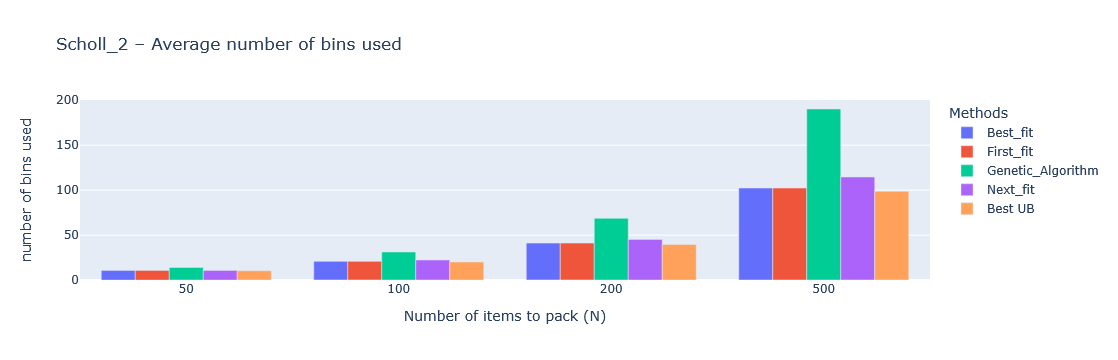

In [40]:
plot_category_metric_by_n('Scholl_2', 'BIN_NUMBER')

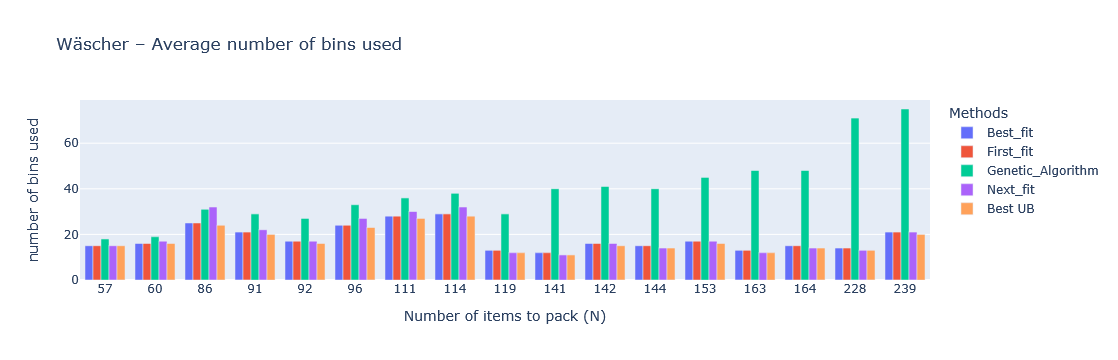

In [36]:
plot_category_metric_by_n('Wäscher', 'BIN_NUMBER')

# Average time elapsed [ms]

In [37]:
# for cat in categories:
#     plot_category_metric_by_n(cat, 'ELAPSED_TIME_MS')

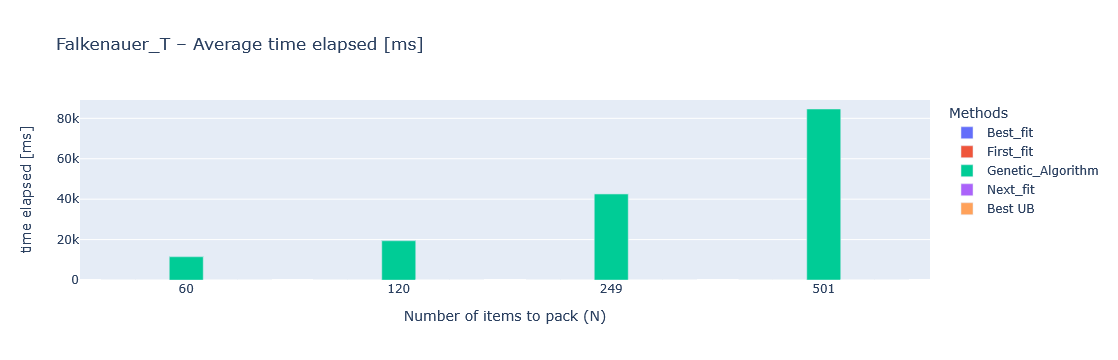

In [38]:
plot_category_metric_by_n('Falkenauer_T', 'ELAPSED_TIME_MS')

# Average gap to best knwon solution

In [41]:
# for cat in categories:
#     plot_category_metric_by_n(cat, 'GAP')

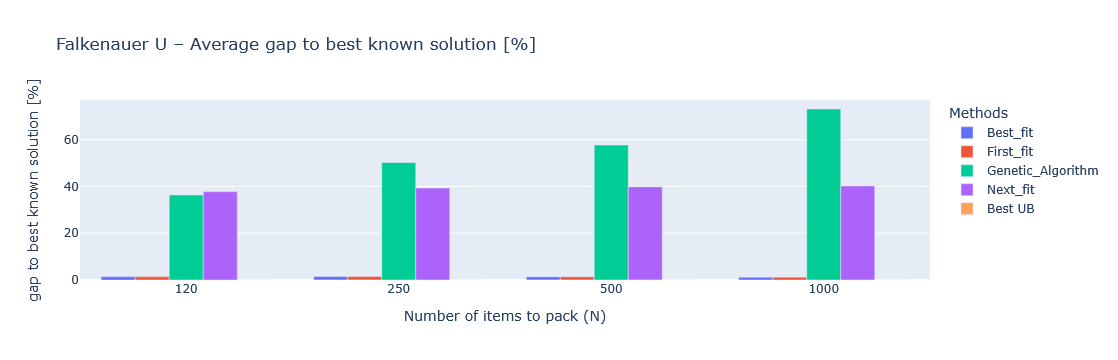

In [43]:
plot_category_metric_by_n('Falkenauer U', 'GAP')

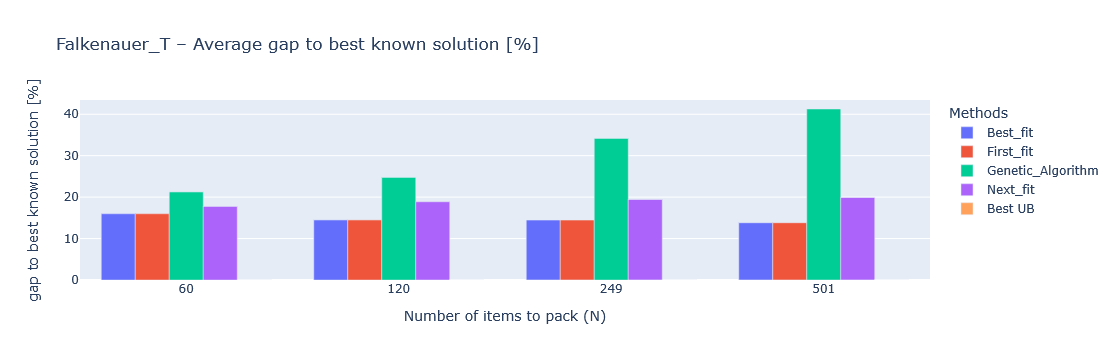

In [44]:
plot_category_metric_by_n('Falkenauer_T', 'GAP')

# Average number of bins used by number of items to pack for each capacity (Scholl_1)

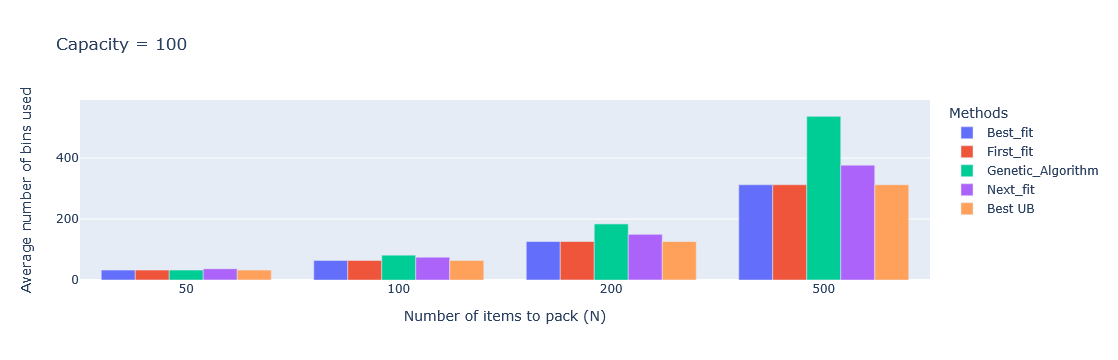

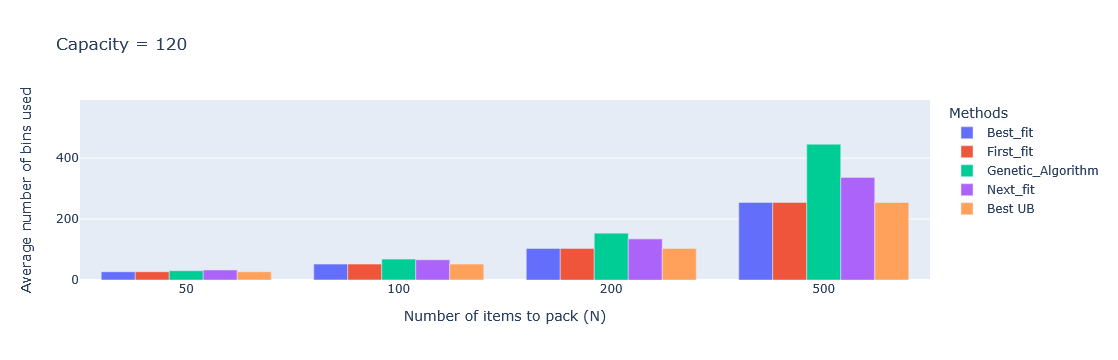

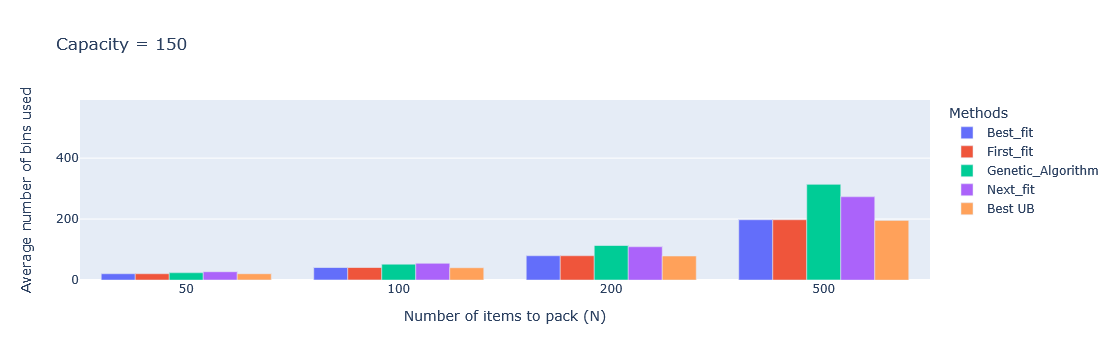

In [46]:
cat_data = plot_data[plot_data['CATEGORY'] == 'Scholl_1'].copy()
cat_data['N'] = cat_data['N'].astype(str)

max_y = cat_data['BIN_NUMBER'].max() * 1.1 

for capacity in [100, 120, 150]:
    sub = cat_data[cat_data['BIN_CAPACITY'] == capacity]
    fig = px.bar(
        sub,
        x='N',
        y='BIN_NUMBER',
        color='METHOD_NAME',
        barmode='group',
        title=f'Capacity = {capacity}'
    )
    fig.update_layout(
        xaxis_title='Number of items to pack (N)',
        yaxis_title='Average number of bins used',
        legend_title_text='Methods',
        yaxis_range=[0, max_y]
    )
    fig.show()